# Ternary stochastic neuron

## goal of the notebook
- To develop a model of ternary stochastic neuron in `JAX`
- Show the transitions between the states as a function of the noise-free input.
- Subject the model to gaussian additive noise.
- One of the later aims could also be to characterize the gradient. Comparing the empirical and the calculated values.



In [1]:
import jax
import jax.numpy as jnp
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader


from sklearn.datasets import make_moons

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

In [2]:
from tqdm.notebook import tqdm

In [3]:
DATA_PATH = f"/Users/vikrantjaltare/OneDrive - UC San Diego/Datasets/"
FIGURES_PATH = f"/Users/vikrantjaltare/OneDrive - UC San Diego/Figures/onr_figures/"

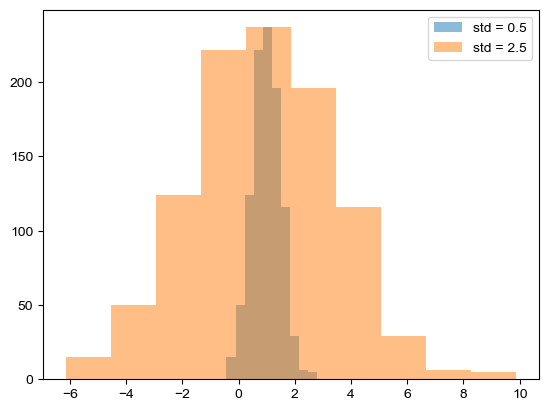

In [4]:
## Try: generating random numbers
key1 = jax.random.key(1)
mu1 = 1.0
std1 = 0.5
zeta_arr1 = mu1 + jax.random.normal(key1, (1000,))*std1
zeta_arr2 = mu1 + jax.random.normal(key1, (1000,))*std1*5
plt.hist(zeta_arr1, alpha =.5, label = f"std = {std1}")
plt.hist(zeta_arr2, alpha =.5, label=f"std = {std1*5}")

plt.legend()


In [139]:
## create a neuron model
@jax.jit
def state_function(x, thresholds, std, key):
    """
    Implements ternary state updates for vector inputs.
    x: Input vector
    thresholds: Two-element array of thresholds [theta1, theta2]
    """

    theta1, theta2 = thresholds

    noise = jax.random.normal(key, x.shape) * std
    x = x + noise


    # Apply element-wise thresholding using jax.numpy.where (which supports vectorization)
    state = jnp.where(x < theta1, -1, 
                      jnp.where(x > theta2, 1, 0))

    return state



# @jax.jit
# def activation(W, b, x):
#     return jnp.dot(W, x) + b

# @jax.jit
# def generate_keys(init_key = 101, num_keys = 1000):
#     key = jax.random.key(init_key)
#     return jax.random.split(key, num = num_keys)

# @jax.jit
# def generate_gaussian_noise(key, mean, std, size):
#     """
#     Generate random samples from a Gaussian distribution of a given size
#     """
#     return mean + jax.random.normal(key, (size,)) * std

@jax.jit
def gaussian_erf(x, mu, sigma):
    """
    Gaussian error function. 
    To compute survivor function simply use 1 - erf
    """
    return 0.5 * (1 + jax.lax.erf((x - mu) / (sigma * jnp.sqrt(2))))

@jax.jit
def expected_state(y_tilde, threshold, std):
    """"
    Calculate the expected state.
    Assume threshold to be a two element array
    """

    # unpack the thresholds
    theta1, theta2 = threshold

    # calculate the expected state
    E =  (1/(jnp.sqrt(2 * jnp.pi) * std)) * ((1 - gaussian_erf(x = theta2 - y_tilde, mu = 0, sigma = std)) - gaussian_erf(x = theta1 - y_tilde, mu = 0, sigma = std)) # # jax.nn.sigmoid(y_tilde)
    return E


In [6]:
## testing state function
W = jax.random.normal(key1, (3, 3))
x = jax.random.normal(key1, (3,))
print(jnp.dot(x, W.T))
print(state_function(jnp.dot(x, W.T), [-1, 1]))

[-0.9785075 -1.3780545 -1.3985887]
[ 0 -1 -1]


In [135]:
## Defining state function with custom gradients: UNDER CONSTRUCTION
@jax.custom_vjp
def state_fn_with_custom_grad(x, threshold, std, key):
    """
    Implements ternary state updates.
    Uses state_function in the forward pass but overrides the gradient
    with expected state in the backward pass
    """

    return state_function(x, threshold, std, key)

## define the forward pass
def state_fwd(x, threshold, std, key):
    return state_function(x, threshold, std, key), (x, threshold, std) # store x, threshold and std for the backward pass

## define the backward pass
def state_bwd(res, g):
    # unpack the stored values
    x, threshold, std = res

    # use expected_state with passed std value
    grad_x = expected_state(y_tilde = x, threshold = threshold, std = std)

    return (grad_x * g, None, None) # None for threshold and std as they are not differentiable

# Attach custom forward and backward to state_fn_with_custom_grad
state_fn_with_custom_grad.defvjp(state_fwd, state_bwd)

# Defining the architecture

In [136]:
## Helper function to initialize the weights 
def random_layer_params(input_size, output_size, key):
    """
    Initialize the weights and biases for a single layer
    """
    scale = jnp.sqrt(2/(input_size + output_size))
    w_key, b_key = jax.random.split(key)
    W = jax.random.normal(w_key, (output_size, input_size)) * scale
    b = jax.random.normal(b_key, (output_size, )) * scale

    return W, b

## Initialize all the layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    """
    Initialize the weights and biases for all the layers
    """

    keys = jax.random.split(key, len(sizes))
    params = [random_layer_params(n_in, n_out, k) for n_in, n_out, k in zip(sizes[:-1], sizes[1:], keys)]
    return params

## Initialize Adam parameters
def init_adam_params(params):
    """
    Initialize the Adam parameters
    """

    # 1st order term
    m = [(jnp.zeros_like(w), jnp.zeros_like(b)) for w, b in params]
    # 2nd order term
    v = [(jnp.zeros_like(w), jnp.zeros_like(b)) for w, b in params]
    # initialize time
    t = 1

    return m, v, t


## Forward pass through the network
def predict(params, image, thresholds, key, noise_sd):
    """
    Forward pass through the network
    """

    # generate a key
    key = jax.random.key(key)

    # Unpack the image
    activations = image

    # print(f"Activations.shape inside predict {activations.shape}")

    for i, (W, b) in enumerate(params[:-1]): # iterate through all but final layer
        
        # split the key
        key, noise_key = jax.random.split(key, 2)

        # comput noise-free input
        y_tilde = jnp.dot(activations, W.T) + b

        # # compute the expected state
        # activations = expected_state(y_tilde=y_tilde, threshold = thresholds, std = noise_sd)

        # # add noise to y_tilde: y = y_tilde + noise
        # noise = noise_sd * jax.random.normal(noise_key, activations.shape)
        # outputs = y_tilde + noise

        # Apply thresholding function here
        activations = state_fn_with_custom_grad(y_tilde, thresholds, noise_sd, noise_key)


        # activations = state_function(outputs, thresholds)
        # print(activations)

    # for final layer no thresholding!
    out_W, out_b = params[-1]
    logits = jnp.dot(activations, out_W.T) + out_b

    return logits # this is because we are taking log_softmax in the loss calculation function

## dealing with batches using vmap
batched_predict = jax.vmap(predict, in_axes = (None, 0, None, None, None)) # params, inputs, thresholds, key, noise_sd

## define a one hot encoding function
def one_hot(x, k, dtype = jnp.float32):
    """
    One hot encoding
    """
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

## define an accuracy function
def accuracy(params, images, targets, thresholds, key, noise_sd):
    """
    Calculate the accuracy of the model
    """
    target_class = jnp.argmax(targets, axis = 1)
    predicted_class = jnp.argmax(batched_predict(params, images, thresholds, key, noise_sd), axis = 1)
    mean_acc = jnp.mean(predicted_class == target_class)

    return mean_acc

# def loss(params, images, targets):
#   preds = batched_predict(params, images)
#   return -jnp.mean(preds * targets)

def ce_loss(params, images, targets, thresholds, key, noise_sd):
    """
    Calculate the cross entropy loss: Rewrite this to incorporate batch size!!
    """

    # make predictions
    logits = batched_predict(params, images, thresholds, key, noise_sd)

    # compute the cross-entropy loss
    log_softmax = jax.nn.log_softmax(logits)

    # compute the cross-entropy loss
    loss = -jnp.sum(log_softmax * targets)

    # add L2 penmalty
    l2_penalty = 0 #0.5 * sum(jnp.sum(jnp.square(w)) for w, _ in params)

    return jnp.mean(loss) + 1e-4*l2_penalty

## define two update functions: one for SGD and one for Adam

@jax.jit
def update_with_sgd(params, x, y, thresholds, key, noise_sd, lr):
    """
    Update parameters usinf SGD
    """
    
    # partially apply the non-differentiable arguments to ce_loss
    loss_fn = partial(ce_loss, thresholds = thresholds, key = key, noise_sd = noise_sd)

    # comput the gradients w.r.t. the parameters
    grads = jax.grad(loss_fn)(params, x, y)

    # update the parameters
    return [(w - lr * dw, b - lr * db) for (w, b), (dw, db) in zip(params, grads)]


@jax.jit
def update_with_adam(params, x, y, thresholds, key, noise_sd, optim_state, lr_adam = 1e-3, beta1 = 0.9, beta2 = 0.999, epsi = 1e-8):
    """
    Update the parameters using Adam
    """

    # partially apply the non-differentiable arguments to ce_loss
    loss_fn = partial(ce_loss, thresholds = thresholds, key = key, noise_sd = noise_sd)

    # comput the gradients w.r.t. the parameters
    grads = jax.grad(loss_fn)(params, x, y)

    # extract parameters from the optimizer state
    m, v, t = optim_state # for JAX: storing internal states explicitly is requried

    new_params = []
    new_m = []
    new_v = []

    for (w, b), (dw, db), (m_w, m_b), (v_w, v_b) in zip(params, grads, m, v):
        # update the first order moment
        m_w = beta1 * m_w + (1 - beta1) * dw
        m_b = beta1 * m_b + (1 - beta1) * db

        # update the second order moments
        v_w = beta2 * v_w + (1 - beta2) * dw**2
        v_b = beta2 * v_b + (1 - beta2) * db**2

        # compute the bias correct moment estimates
        m_w_hat = m_w/(1 - beta1**t)
        m_b_hat = m_b/(1 - beta1**t)
        v_w_hat = v_w/(1 - beta2**t)
        v_b_hat = v_b/(1 - beta2**t)

        # update the parameters
        w_new = w - lr_adam * m_w_hat/(jnp.sqrt(v_w_hat) + epsi)
        b_new = b - lr_adam * m_b_hat/(jnp.sqrt(v_b_hat) + epsi)

        # append updated params 
        new_params.append((w_new, b_new))
        new_m.append((m_w, m_b))
        new_v.append((v_w, v_b))



    # increment time
    t = t + 1

    # return updated parameters and updated Adam states

    return new_params, (new_m, new_v, t)




## define a param update function
@jax.jit
def update(params, x, y, thresholds, key, noise_sd, lr, opt_state, optimizer = 0):
    """
    Update the model parameters.
    Update the function to incorporate Adam.
    As strings are not JAX compatible, we will use 0 for SGD and 1 for Adam
    """

    # partially apply the non-differentiable arguments to ce_loss
    loss_fn = partial(ce_loss, thresholds = thresholds, key = key, noise_sd = noise_sd)

    # comput the gradients w.r.t. the parameters
    grads = jax.grad(loss_fn)(params, x, y)

    def sgd_update(args):
        params, grads, lr, _ = args
        new_params = [(w - lr * dw, b - lr * db) for (w, b), (dw, db) in zip(params, grads)]
        return new_params, None
    
    def adam_update(args):
        params, grads, opt_state, lr = args
        # declare the hypterparameters as recommended in the original paper
        [beta1, beta2, epsi, lr_adam] = [0.9, 0.999, 1e-8, 1e-3]
        m, v, t = opt_state # for JAX: storing internal states explicitly is requried
        # extract parameters from the optimizer state
        m, v, t = opt_state # for JAX: storing internal states explicitly is requried

        new_params = []
        new_m = []
        new_v = []

        for (w, b), (dw, db), (m_w, m_b), (v_w, v_b) in zip(params, grads, m, v):
            # update the first order moment
            m_w = beta1 * m_w + (1 - beta1) * dw
            m_b = beta1 * m_b + (1 - beta1) * db

            # update the second order moments
            v_w = beta2 * v_w + (1 - beta2) * dw**2
            v_b = beta2 * v_b + (1 - beta2) * db**2

            # compute the bias correct moment estimates
            m_w_hat = m_w/(1 - beta1**t)
            m_b_hat = m_b/(1 - beta1**t)
            v_w_hat = v_w/(1 - beta2**t)
            v_b_hat = v_b/(1 - beta2**t)

            # update the parameters
            w_new = w - lr_adam * m_w_hat/(jnp.sqrt(v_w_hat) + epsi)
            b_new = b - lr_adam * m_b_hat/(jnp.sqrt(v_b_hat) + epsi)

            # append updated params 
            new_params.append((w_new, b_new))
            new_m.append((m_w, m_b))
            new_v.append((v_w, v_b))



        # increment time
        t = t + 1

        # return updated parameters and updated Adam states

        return new_params, (new_m, new_v, t)
    
    return jax.lax.cond(
        optimizer == 0,
        sgd_update, 
        adam_update,
        (params, grads, lr), 
        (params, grads, opt_state, lr)
    )


    # # SGD
    # if optimizer == 0:
    #     return [(w - lr * dw, b - lr * db) for (w, b), (dw, db) in zip(params, grads)]
    
    # elif optimizer == 1:
    #     ## TODO

        
    #     [beta1, beta2, epsi, lr_adam] = [0.9, 0.999, 1e-8, 1e-3]

    #     # extract parameters from the optimizer state
    #     m, v, t = opt_state # for JAX: storing internal states explicitly is requried

    #     new_params = []
    #     new_m = []
    #     new_v = []

    #     for (w, b), (dw, db), (m_w, m_b), (v_w, v_b) in zip(params, grads, m, v):
    #         # update the first order moment
    #         m_w = beta1 * m_w + (1 - beta1) * dw
    #         m_b = beta1 * m_b + (1 - beta1) * db

    #         # update the second order moments
    #         v_w = beta2 * v_w + (1 - beta2) * dw**2
    #         v_b = beta2 * v_b + (1 - beta2) * db**2

    #         # compute the bias correct moment estimates
    #         m_w_hat = m_w/(1 - beta1**t)
    #         m_b_hat = m_b/(1 - beta1**t)
    #         v_w_hat = v_w/(1 - beta2**t)
    #         v_b_hat = v_b/(1 - beta2**t)

    #         # update the parameters
    #         w_new = w - lr_adam * m_w_hat/(jnp.sqrt(v_w_hat) + epsi)
    #         b_new = b - lr_adam * m_b_hat/(jnp.sqrt(v_b_hat) + epsi)

    #         # append updated params 
    #         new_params.append((w_new, b_new))
    #         new_m.append((m_w, m_b))
    #         new_v.append((v_w, v_b))



    #     # increment time
    #     t = t + 1

    #     # return updated parameters and updated Adam states

    #     return new_params, (new_m, new_v, t)




In [88]:
# load MNIST using tensorflow
temp_data_dir = DATA_PATH
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=temp_data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)


In [114]:
print('Train:', train_images.shape, train_labels.shape)
print('Test:', test_images.shape, test_labels.shape)


Train: (60000, 784) (60000, 10)
Test: (10000, 784) (10000, 10)


In [140]:
## initializing the network: in the future this should be a dictionary
threshold = [-2, 1]
layer_size = [784, 2098, 10]
num_epochs = 5
batch_size = 128
n_targets = 10
net_params = init_network_params(layer_size, jax.random.key(0))

opti_dict = {
    'SGD': 0,
    'Adam': 1
}



# batched_predictions = batched_predict(net_params, flattened_images)


  0%|          | 0/5 [00:00<?, ?it/s]

Noise SD sim: 10
std Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=2/1)>, noise = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/1)>
Training set accuracy 0.09266667068004608
Test set accuracy 0.09129999577999115
Noise SD sim: 10
Training set accuracy 0.9419000148773193
Test set accuracy 0.9341999888420105
Noise SD sim: 10
Training set accuracy 0.9601333737373352
Test set accuracy 0.9431999921798706
Noise SD sim: 10
Training set accuracy 0.9681666493415833
Test set accuracy 0.9456999897956848
Noise SD sim: 10
Training set accuracy 0.9728000164031982
Test set accuracy 0.946899950504303


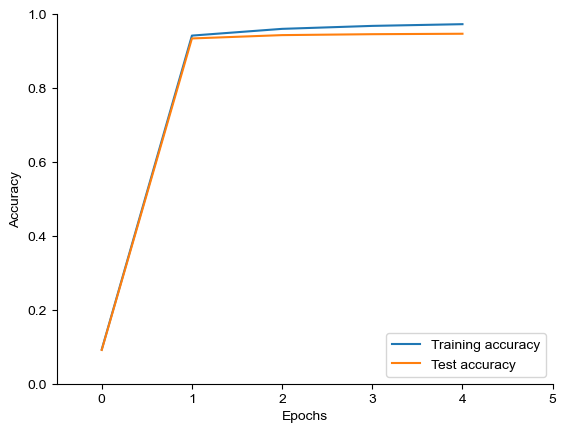

In [141]:
def get_train_batches():
  
  # as_supervised=True gives us the (image, label) as a tuple instead of a dict
  ds = tfds.load(name='mnist', split='train', as_supervised=True, data_dir = DATA_PATH)
  # You can build up an arbitrary tf.data input pipeline
  ds = ds.batch(batch_size).prefetch(1)
  # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
  return tfds.as_numpy(ds)

train_acc_list = []
test_acc_list = []
noise_sd_sim = 10
noise_sd_inf = 10
lr_sim = 1e-4
(m, v, t) = init_adam_params(net_params)
opti = 1

for epoch in tqdm(range(num_epochs)):
  # Compute accuracy at the start of the epoch
  print(f"Noise SD sim: {noise_sd_sim}")
  train_acc = accuracy(params=net_params, images=train_images, targets=train_labels, thresholds = threshold, key = 0, noise_sd = noise_sd_inf)
  test_acc = accuracy(params=net_params, images=test_images, targets=test_labels, thresholds = threshold, key = 0, noise_sd = noise_sd_inf)
  train_acc_list.append(train_acc)
  test_acc_list.append(test_acc)
  print(f"Training set accuracy {train_acc}")
  print(f"Test set accuracy {test_acc}")

  for x, y in get_train_batches():
    x = jnp.reshape(x, (len(x), num_pixels))
    # print(x.shape)
    # break
    y = one_hot(y, num_labels)
    net_params, (m, v, t) = update_with_adam(net_params, x ,y, threshold, key = 0, noise_sd = noise_sd_sim, optim_state = (m, v, t))
    # if opti == 0:
    #   net_params, _ = update(params = net_params, x = x, y = y, thresholds = threshold, key = 0, noise_sd = noise_sd_sim, lr = lr_sim, optimizer = 0, opt_state = None)
    # else:
    #   net_params, (m, v, t) = update(params = net_params, x = x, y = y, thresholds = threshold, key = 0, noise_sd = noise_sd_sim, lr = lr_sim, optimizer = 1, opt_state = (m, v, t))

#   train_acc = accuracy(params=net_params, images=train_images, targets=train_labels, thresholds = threshold, key = 0, noise_sd = noise_sd_inf)
#   test_acc = accuracy(params=net_params, images=test_images, targets=test_labels, thresholds = threshold, key = 0, noise_sd = noise_sd_inf)
#   train_acc_list.append(train_acc)
#   test_acc_list.append(test_acc)
#   print("Training set accuracy {}".format(train_acc))
#   print("Test set accuracy {}".format(test_acc))

#   # annealing??
  # noise_sd_sim = noise_sd_sim * 0.7
  # noise_sd_inf = noise_sd_inf * 0.7


## Plotting the results
fig, ax = plt.subplots()
ax.plot(train_acc_list, label = "Training accuracy")
ax.plot(test_acc_list, label = "Test accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.set_xlim([-0.5, num_epochs])
ax.set_ylim([0, 1])

sns.despine()

## Analyzing the accuracy as a function of noise standard deviation

In [129]:
## initialize noise sd to sweep
noise_sd_arr = jnp.logspace(-5, 2, 11)
print(noise_sd_arr)

## initializing the network: in the future this should be a dictionary
threshold = [-1, 1]
layer_size = [784, 2048, 10]
num_epochs = 5
batch_size = 128
n_targets = 10

## initialize the finaly accuracies
final_train_acc = []
final_test_acc = []

for noise_sd in tqdm(noise_sd_arr):
    print(f"Running simulation for noise_sd = {noise_sd}")

    # initialize the weights
    net_params = init_network_params(layer_size, jax.random.key(0))

    train_acc_list = []
    test_acc_list = []

    for epoch in range(num_epochs):
        # Compute accuracy at the start of the epoch
        train_acc = accuracy(params=net_params, images=train_images, targets=train_labels, thresholds = threshold, key = 0, noise_sd = noise_sd)
        test_acc = accuracy(params=net_params, images=test_images, targets=test_labels, thresholds = threshold, key = 0, noise_sd = noise_sd)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        for x, y in get_train_batches():
            x = jnp.reshape(x, (len(x), num_pixels))
            # print(x.shape)
            # break
            y = one_hot(y, num_labels)
            net_params = update_with_adam(net_params, x ,y, threshold, key = 0, noise_sd = noise_sd_sim, optim_state = (m, v, t))

    final_train_acc.append(train_acc_list[-1])
    final_test_acc.append(test_acc_list[-1])


## Plotting the results
fig, ax = plt.subplots()
ax.semilogx(noise_sd_arr, final_train_acc, label = "Training accuracy")
ax.semilogx(noise_sd_arr, final_test_acc, label = "Test accuracy")
ax.set_xlabel("Noise SD")
ax.set_ylabel("Accuracy")
ax.legend()


[9.9999997e-06 5.0118757e-05 2.5118855e-04 1.2589259e-03 6.3095726e-03
 3.1622775e-02 1.5848938e-01 7.9432833e-01 3.9810724e+00 1.9952631e+01
 1.0000000e+02]


  0%|          | 0/11 [00:00<?, ?it/s]

Running simulation for noise_sd = 9.999999747378752e-06


2024-10-24 22:49:06.881812: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TypeError: add got incompatible shapes for broadcasting: (2098, 784), (2048, 784).

In [17]:
# for x, y in get_train_batches():
#     x = jnp.reshape(x, (len(x), num_pixels))  # Flatten input to (batch_size, 784)
#     y = one_hot(y, num_labels)

#     # Check the shape before applying batched_predict
#     print(f"Before batched_predict: {x.shape}")  # Should be (batch_size, 784)

#     logits = batched_predict(net_params, x, threshold, 0, 0.0001)

#     # Check the shape after batched_predict
#     print(f"After batched_predict: {logits.shape}")
    
#     net_params = update(params=net_params, x=x, y=y, thresholds=threshold, key=0, noise_sd=0.1, lr=0.1)

In [20]:
# plt.imshow(net_params[1][0], cmap = "viridis")

In [71]:
# ## load MNIST using Pytorch
# def jax_transform(x):
#     """Flatten and convert to JAX array."""
#     return jnp.ravel(jnp.array(x, dtype=jnp.float32)) / 255.0  # Normalize to [0, 1]

# ## Custom collate function for batching
# def jax_custom_collate(batch):
#     """Collate function to prepare data and labels for JAX."""
#     transposed_data = list(zip(*batch))
    
#     # Labels as JAX arrays (int32)
#     labels = jnp.array(transposed_data[1], dtype=jnp.int32)
    
#     # Data as stacked JAX arrays
#     data = jnp.stack(transposed_data[0], axis=0)
    
#     return data, labels

# # ## Data loading parameters
# # data_params = {
# #     "batch_size": 128,
# #     "num_workers": 0,
# #     "pin_memory": False,
# #     "shuffle": True
# # }

# ## Load MNIST datasets using PyTorch's torchvision
# train_dataset = datasets.MNIST(root=DATA_PATH, train=True, download=False, transform=jax_transform)
# test_dataset = datasets.MNIST(root=DATA_PATH, train=False, download=False, transform=jax_transform)

# ## Create DataLoader for training and test datasets
# train_loader = DataLoader(train_dataset, collate_fn=jax_custom_collate, drop_last=True, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, collate_fn=jax_custom_collate, drop_last=True, batch_size = batch_size)




In [72]:
# # Get the first batch from the training loader and print the shapes
# train_images, train_labels = next(iter(train_loader))
# print(f"Train set images shape: {train_images.shape}")
# print(f"Train set labels shape: {train_labels.shape}")

# # Get the first batch from the test loader and print the shapes
# test_images, test_labels = next(iter(test_loader))
# print(f"Test set images shape: {test_images.shape}")
# print(f"Test set labels shape: {test_labels.shape}")

# print(f"Total number of training samples: {len(train_dataset)}")
# print(f"Total number of testing samples: {len(test_dataset)}")

Train set images shape: (128, 784)
Train set labels shape: (128,)
Test set images shape: (128, 784)
Test set labels shape: (128,)
Total number of training samples: 60000
Total number of testing samples: 10000


In [88]:
# ## training loop
# num_pixels = 784
# num_labels = 10
# key_ = jax.random.key(0)
# test_accuracy = []
# train_accuracy = []

# for epoch in range(num_epochs):

#     for x_batch, y_batch in train_loader:
#         # Reshape the input images to (batch_size, num_pixels)
#         x_batch = jnp.reshape(x_batch, (len(x_batch), num_pixels))
        
#         # One-hot encode the labels
#         y_batch = one_hot(y_batch, num_labels)
        
#         # Update parameters using the training batch
#         net_params = update(net_params, x_batch, y_batch, thresholds = threshold, key = key_, noise_sd = 0.01, lr = 1e-3)

#     # Calculate accuracy on the training set
#     train_images, train_labels = next(iter(train_loader))
#     train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
#     train_labels = one_hot(train_labels, num_labels)
#     train_acc = accuracy(net_params, train_images, train_labels)
#     train_accuracy.append(train_acc)

#     # Calculate accuracy on the test set
#     test_images, test_labels = next(iter(test_loader))
#     test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
#     test_labels = one_hot(test_labels, num_labels)
#     test_acc = accuracy(net_params, test_images, test_labels)

#     print(f"Training set accuracy {train_acc}")
#     print(f"Test set accuracy {test_acc}")




